In [1]:
import random
import math
import numpy as np
import pandas as pd
from math import sqrt as sqrt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats

from statsmodels.tsa.api import SARIMAX

import copulae

from proj_1 import *

seed = 8227185 #for sigma to sq repara

Clayton Copula Summary
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 2.0



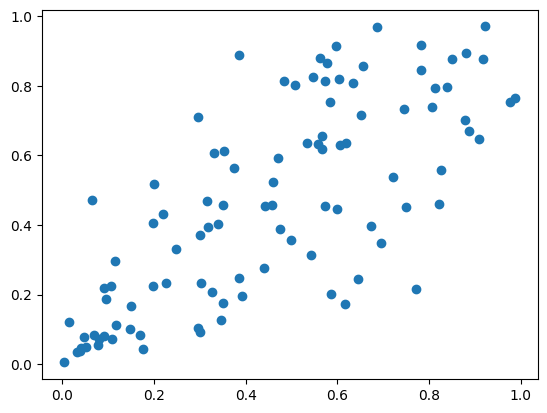

In [2]:
cop = copulae.archimedean.ClaytonCopula(theta = 2) #dim = 2 == default
print(cop.summary())
u_gen = cop.random(100, seed = 10)

plt.scatter(u_gen[:,0], u_gen[:,1])

In [3]:
#ar4: the last stable result 
#u = [0.1,0.1,0.1, 0.1, 0.1]
#p = len(u)
p1 = 10
#v = np.tanh(u)
v = [0.7 for i in range(p1)] #slightly different initial setup due to experimenting with values 
psi1 = barndorff_schou_transformation(v)
sigma21 = 2
print("psi actual", psi1, "sigma2 actual", sigma21)

psi actual [-3.71       -7.1988     -8.600445   -5.58392415  0.84599231  6.69469993
  8.527701    6.37077     2.954       0.7       ] sigma2 actual 2


In [4]:
#ar2

#u = [0.1,0.1,0.1, 0.1, 0.1]
#p = len(u)
p2 = 8
#v = np.tanh(u)
v = [0.7 for i in range(p2)] #slightly different initial setup due to experimenting with values 
psi2 = barndorff_schou_transformation(v)
sigma22 = 6
print("psi actual", psi2, "sigma2 actual", sigma22)

psi actual [-2.73       -3.7835     -2.61779     0.41944119  3.1135832   3.6302
  2.268       0.7       ] sigma2 actual 6


In [5]:
N = 1000
horizon = 20
y1, X1, y2, X2, y1_test, y2_test = gen_data_copula(cop, psi1,psi2,  sigma21, sigma22, N = N, horizon = horizon, seed = 1 )

N = N - horizon

ar8 fitting y1

In [6]:
param_i = [0.1 for i in range(p1+1)]
np.random.seed(seed)

sarimax_mod = SARIMAX(y1, order=(p1, 0, 0), trend="n")
sarimax_res1 = sarimax_mod.fit()
print(sarimax_res1.summary())

sarimax_params = sarimax_res1.arparams
results_as_html = sarimax_res1.summary().tables[1].as_html()
res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]
sarimax_sig = list(res_pd["coef"])[-1]
#sarimax_sig = np.var(sarimax_res.resid) 
non_restricted = np.arctanh(ARToPacf(sarimax_params))
param_i = list(non_restricted) + [exp_to_sigma2(sarimax_sig)]


results1 = minimize(neg_log_lik, param_i, args = ((y1, X1)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results1.x[0:len(psi1)])), "sigma2 approx",sigma2_to_exp(results1.x[-1]))
print("final negative log likelihood", results1.fun)

#forecast values 
phi_approx1 = barndorff_schou_transformation(np.tanh(results1.x[0:p1]))
forecast_y1 = predicting_values(y1, p1, N, phi_approx1, forecast_len = horizon)

#fitting values 
phi_approx1 = np.array(phi_approx1)
#phi_approx = sarimax_res1.arparams # to check if identical fitting values
fitted_y1 = fitting_values(y1,p1, phi_approx1)

#mse for fitted 
print("MSE of fitted to true for SARIMAX initials", mse(y1[p1:N], fitted_y1))
print("MSE of fitted to true for SARIMAX initials", mse(y1_test , forecast_y1))


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  970
Model:              SARIMAX(10, 0, 0)   Log Likelihood               -2053.390
Date:                Thu, 08 Aug 2024   AIC                           4128.780
Time:                        14:15:28   BIC                           4182.430
Sample:                             0   HQIC                          4149.201
                                - 970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.6759      0.024   -155.993      0.000      -3.722      -3.630
ar.L2         -7.0893      0.077    -91.812      0.000      -7.241      -6.938
ar.L3         -8.4211      0.134    -62.823      0.0

C:\Users\danie\AppData\Local\Temp\ipykernel_10180\766897554.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]


copula uniform

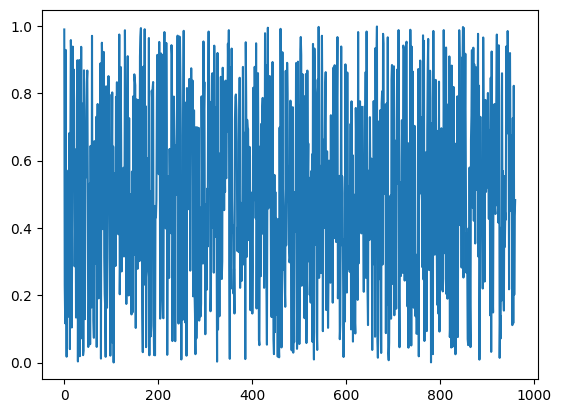

In [7]:
# Transform to uniform marginals
U_1t_sim = stats.norm.cdf(y1[p1:(len(y1)+1)], fitted_y1, np.sqrt(sigma2_to_exp(results1.x[-1]) ) ) #pnorm
data_sim = pd.DataFrame(U_1t_sim, columns = ["U_1t_sim"])
data_sim.to_csv("U_1t_sim.csv")

plt.plot(U_1t_sim)
plt.show()

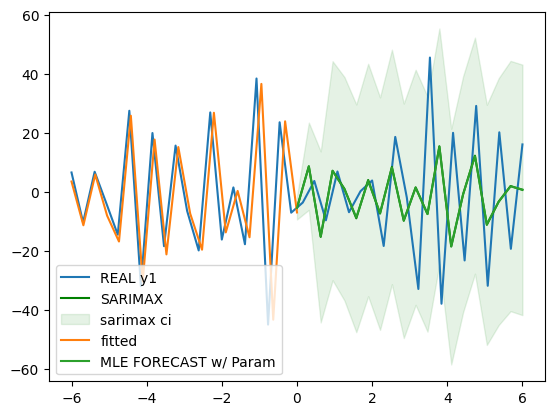

In [8]:
#prepping graph arrays

sarimax_ci_down = sarimax_res1.get_forecast(horizon).summary_frame()["mean_ci_lower"]
sarimax_ci_up = sarimax_res1.get_forecast(horizon).summary_frame()["mean_ci_upper"]

y_graph = list(y1[-horizon:N])
y_graph = y_graph + list(y1_test)

fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,horizon*2),y_graph)


ax.plot(np.linspace(0,6,horizon),sarimax_res1.forecast(horizon), color = "green")
ax.fill_between(np.linspace(0,6,horizon), sarimax_ci_up, sarimax_ci_down, color='green', alpha=.1)

ax.plot(np.linspace(-6,0,horizon) ,fitted_y1[-horizon:N])
plt.plot(np.linspace(0,6,horizon),forecast_y1)

plt.legend([ "REAL y1","SARIMAX", "sarimax ci",  "fitted", "MLE FORECAST w/ Param"])

plt.show()

y2: ar6

In [9]:
param_i = [0.1 for i in range(p2+1)]
np.random.seed(seed)

sarimax_mod = SARIMAX(y2, order=(p2, 0, 0), trend="n")
sarimax_res2 = sarimax_mod.fit()
print(sarimax_res2.summary())

sarimax_params = sarimax_res2.arparams
results_as_html = sarimax_res2.summary().tables[1].as_html()
res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]
sarimax_sig = list(res_pd["coef"])[-1]
#sarimax_sig = np.var(sarimax_res.resid) 
non_restricted = np.arctanh(ARToPacf(sarimax_params))
param_i = list(non_restricted) + [exp_to_sigma2(sarimax_sig)]


results2 = minimize(neg_log_lik, param_i, args = ((y2, X2)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results2.x[0:len(psi2)])), "sigma2 approx",sigma2_to_exp(results2.x[-1]))
print("final negative log likelihood", results2.fun)

#forecast values 
phi_approx2 = barndorff_schou_transformation(np.tanh(results2.x[0:p2]))
forecast_y2 = predicting_values(y2, p2, N, phi_approx2, forecast_len = horizon)

#fitting values 
phi_approx2 = np.array(phi_approx2)
#phi_approx = sarimax_res2.arparams # to check if identical fitting values
fitted_y2 = fitting_values(y2,p2, phi_approx2)

#mse for fitted 
print("MSE of fitted to true for SARIMAX initials", mse(y2[p2:N], fitted_y2))
print("MSE of fitted to true for SARIMAX initials", mse(y2_test , forecast_y2))


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  972
Model:               SARIMAX(8, 0, 0)   Log Likelihood               -3153.253
Date:                Thu, 08 Aug 2024   AIC                           6324.507
Time:                        14:15:29   BIC                           6368.421
Sample:                             0   HQIC                          6341.220
                                - 972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.7423      0.021   -132.860      0.000      -2.783      -2.702
ar.L2         -3.8042      0.047    -80.380      0.000      -3.897      -3.711
ar.L3         -2.6446      0.054    -48.838      0.0

C:\Users\danie\AppData\Local\Temp\ipykernel_10180\742206081.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]


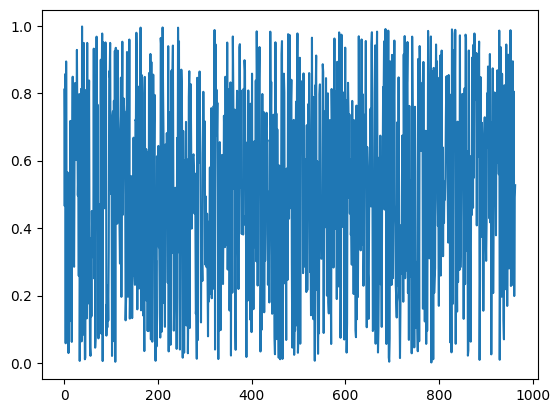

In [10]:
# Transform to uniform marginals
U_2t_sim = stats.norm.cdf(y2[p2:(len(y2)+1)], fitted_y2, np.sqrt(sigma2_to_exp(results2.x[-1]) ) ) #pnorm
data_sim = pd.DataFrame(U_2t_sim, columns = ["U_2t_sim"])
data_sim.to_csv("U_2t_sim.csv")

plt.plot(U_2t_sim)
plt.show()

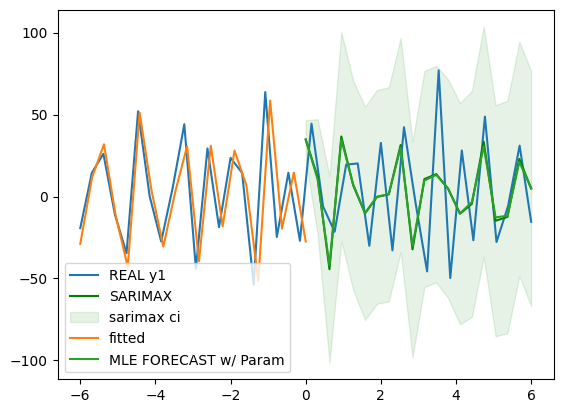

In [11]:
#prepping graph arrays

sarimax_ci_down = sarimax_res2.get_forecast(horizon).summary_frame()["mean_ci_lower"]
sarimax_ci_up = sarimax_res2.get_forecast(horizon).summary_frame()["mean_ci_upper"]

y_graph = list(y2[-horizon:N])
y_graph = y_graph + list(y2_test)

fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,horizon*2),y_graph)


ax.plot(np.linspace(0,6,horizon),sarimax_res2.forecast(horizon), color = "green")
ax.fill_between(np.linspace(0,6,horizon), sarimax_ci_up, sarimax_ci_down, color='green', alpha=.1)

ax.plot(np.linspace(-6,0,horizon) ,fitted_y2[-horizon:N])

plt.plot(np.linspace(0,6,horizon),forecast_y2)

plt.legend([ "REAL y1","SARIMAX", "sarimax ci",  "fitted", "MLE FORECAST w/ Param"])

plt.show()

copula 

0      0.989812
1      0.229654
2      0.116640
3      0.929118
4      0.230873
         ...   
955    0.117347
956    0.822429
957    0.201603
958    0.434921
959    0.482858
Name: U_1t_sim, Length: 960, dtype: float64 0      0.894248
1      0.452453
2      0.175053
3      0.565290
4      0.174064
         ...   
955    0.349985
956    0.804933
957    0.198421
958    0.490886
959    0.527146
Name: U_2t_sim, Length: 960, dtype: float64


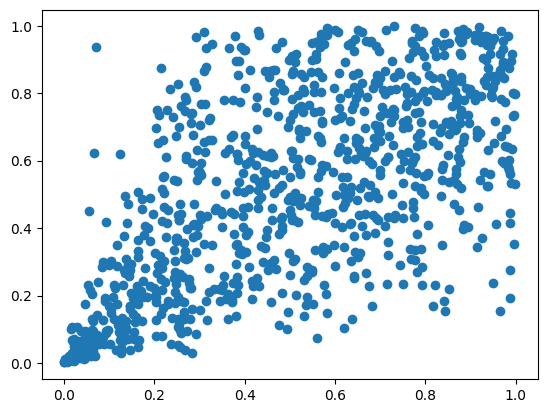

,U_1t,U_2t
count,960.000000,960.000000
mean,0.501626,0.510062
std,0.287480,0.288779
min,0.000337,0.001324
25%,0.254911,0.258531
50%,0.506701,0.524751
75%,0.750035,0.762184
max,0.998658,0.998002


In [12]:
U_1t = pd.read_csv("U_1t_sim.csv")
U_1t = U_1t["U_1t_sim"]

U_2t = pd.read_csv("U_2t_sim.csv")
U_2t = U_2t[4:N] #to make same length
U_2t.reset_index(inplace = True)
U_2t = U_2t["U_2t_sim"]

print(U_1t, U_2t)
plt.scatter(U_1t, U_2t)
plt.show()
data = pd.DataFrame({"U_1t" : U_1t, "U_2t" : U_2t})
display(data.describe())
data = data.to_numpy()

In [13]:
cop = copulae.archimedean.ClaytonCopula() #dim = 2 == default
cop.fit(data)
print(cop.summary())
print(cop.log_lik(data))

Clayton Copula Summary
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.8349893198100267

377.3924470636257


In [14]:
from scipy import stats
tau = stats.kendalltau(data[:,0], data[:,1])[0]
tau
2 * tau / (1 - tau)

1.750947270638277

In [15]:
inita = exp_to_theta(2 * tau / (1 - tau) +1) #sq_to_theta

#results = minimize(neg_log_clayton_pdf, [inita], args = ((rd1, rd2)), method = "nelder-mead")
results = minimize(neg_log_clayton_pdf, x0 = [inita], args = ((data[:,0], data[:,1])), method = "L-BFGS-B")

theta 7.477849976825037
neg log clayton 752.2253496294518
theta 7.477850051603536
neg log clayton 752.2253719227283
theta 2.750947270638277
neg log clayton -322.0009906161223
theta 2.75094729814775
neg log clayton -322.0009876823226
theta 2.36411082784899
neg log clayton -356.26763742522667
theta 2.3641108514900986
neg log clayton -356.2676357853305
theta 1.950987455898288
neg log clayton -375.2476543234622
theta 1.9509874754081624
neg log clayton -375.2476539175247
theta 1.831529179131671
neg log clayton -376.78129067416654
theta 1.831529197446963
neg log clayton -376.7812905881322
theta 1.8006694400239331
neg log clayton -376.85957760176166
theta 1.8006694580306275
neg log clayton -376.85957759520386
theta 1.798146471861422
neg log clayton -376.8600454141722
theta 1.798146489842887
neg log clayton -376.86004541405356
theta 1.7981000230395057
neg log clayton -376.8600455689364
theta 1.798100041020506
neg log clayton -376.8600455689351


Clayton Copula Summary
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.7981000230395057



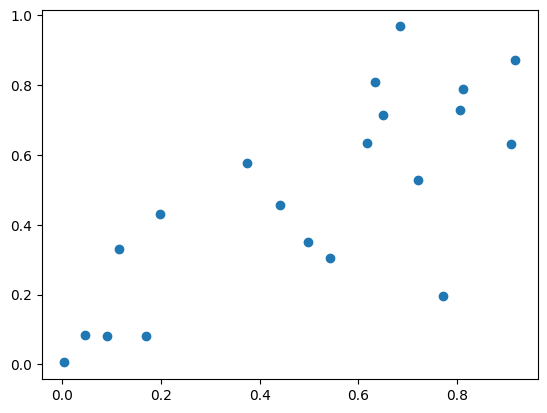

In [16]:
cop = copulae.archimedean.ClaytonCopula(theta = theta_to_exp(results.x +1)) #dim = 2 == default
print(cop.summary())
u_gen = cop.random(horizon, seed = 10)

plt.scatter(u_gen[:,0], u_gen[:,1])

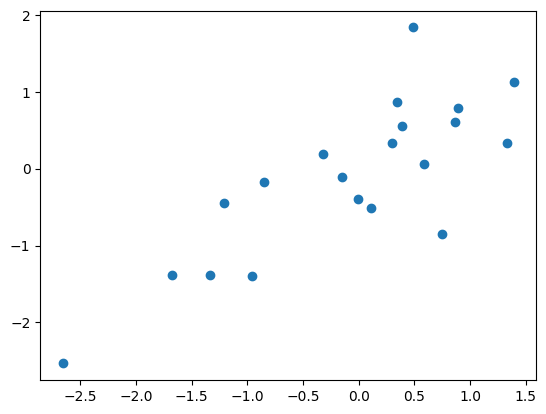

In [17]:
e_1t = stats.norm.ppf(u_gen[:,0])
e_2t = stats.norm.ppf(u_gen[:,1])
plt.scatter(e_1t, e_2t)

In [18]:
#import clayton
#from clayton.rng.archimedean import Clayton
#np.random.seed(10)
#cop = Clayton(theta=-0.028833624534288258, n_samples=horizon)
#u_gen = cop.sample_unimargin()
#
#plt.scatter(u_gen[:,0], u_gen[:,1])
#plt.show()
#e_1t = stats.norm.ppf(u_gen[:,0])
#e_2t = stats.norm.ppf(u_gen[:,1])
#plt.scatter(e_1t, e_2t)

In [19]:
repeats = 10000
pi_1, pi_2, forecast1_param_copula, forecast2_param_copula, pi_1b, pi_2b, forecast1b_param, forecast2b_param = predict_copula_pi(cop, y1, y2, results1, results2, p1, p2, N, N, repeats = repeats, horizon = horizon, seed = 10)

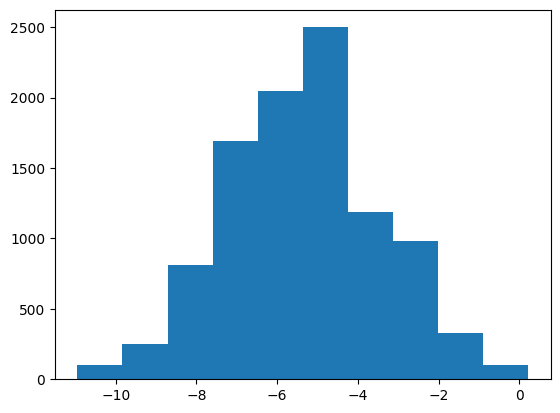

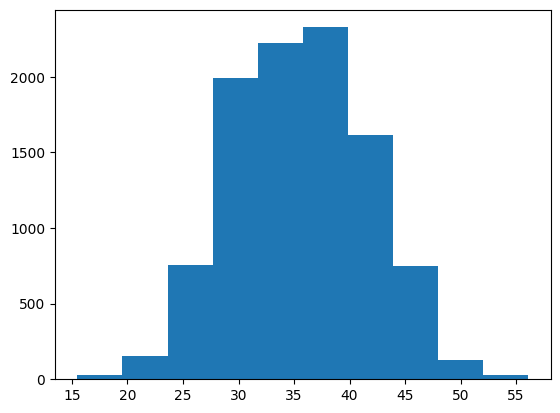

In [20]:
plt.hist(pi_1[0,:])
plt.show()
plt.hist(pi_2[0,:])
plt.show()

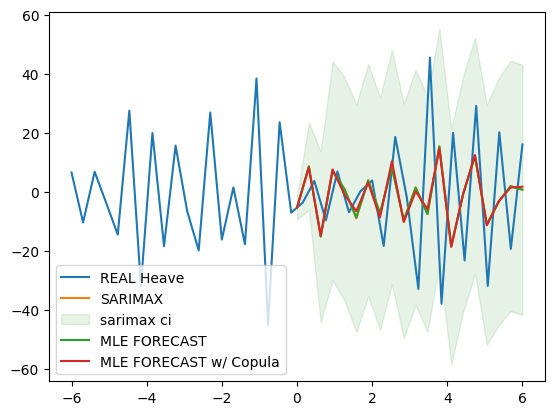

In [21]:
#importing data for graph 

y_graph1 = list(y1[-horizon:N])
y_graph1 = y_graph1 + list(y1_test)

sarimax_ci_down1 = sarimax_res1.get_forecast(horizon).summary_frame()["mean_ci_lower"]
sarimax_ci_up1 = sarimax_res1.get_forecast(horizon).summary_frame()["mean_ci_upper"]


fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,horizon*2),y_graph1)

ax.plot(np.linspace(0,6,horizon),sarimax_res1.forecast(horizon))
ax.fill_between(np.linspace(0,6,horizon), sarimax_ci_up1, sarimax_ci_down1, color='green', alpha=.1)

plt.plot(np.linspace(0,6,horizon),forecast_y1)
plt.plot(np.linspace(0,6,horizon),forecast1_param_copula)



plt.legend([ "REAL Heave","SARIMAX", "sarimax ci",  "MLE FORECAST", "MLE FORECAST w/ Copula"])

plt.show()

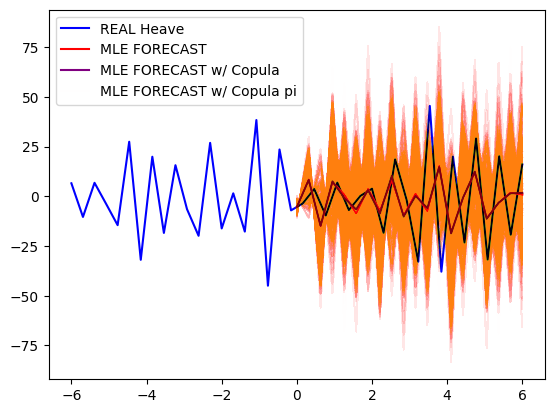

In [22]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-6,6,horizon*2),y_graph1, color = "blue")
plt.plot(np.linspace(0,6,horizon),forecast_y1, color = "red")
plt.plot(np.linspace(0,6,horizon),forecast1_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,horizon),pi_1[:, i],color='C1', alpha=.002) #0.002


plt.legend([  "REAL Heave",  "MLE FORECAST", "MLE FORECAST w/ Copula"  ,"MLE FORECAST w/ Copula pi"])

plt.show()

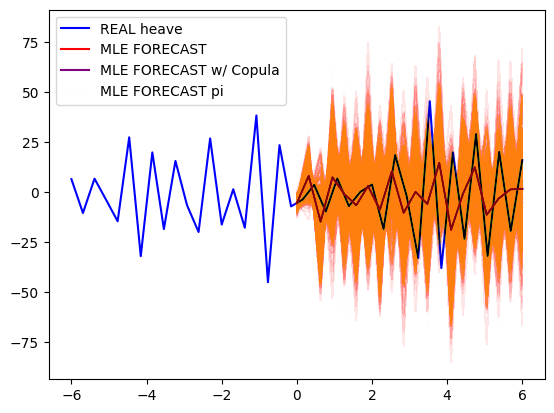

In [23]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-6,6,horizon*2),y_graph1, color = "blue")
plt.plot(np.linspace(0,6,horizon),forecast1b_param, color = "red")
plt.plot(np.linspace(0,6,horizon),forecast1_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,horizon),pi_1b[:, i],color='C1', alpha=.002) #0.002


plt.legend([  "REAL heave",  "MLE FORECAST", "MLE FORECAST w/ Copula"  ,"MLE FORECAST pi"])

plt.show()

In [24]:
print("MSE of predicted to true for MLE",mse(y1_test, forecast1b_param))
print("MSE of predicted to true for MLE w/ copula",mse(y1_test, forecast1_param_copula))

mse(forecast1b_param, forecast1_param_copula)

MSE of predicted to true for MLE [538.95663518]
MSE of predicted to true for MLE w/ copula 537.0445798975752


array([0.02810739])

In [25]:
y_graph2 = list(y2[-horizon:N])
print(len(y_graph2), len(y2_test))
y_graph2 = y_graph2 + list(y2_test)

sarimax_ci_down2 = sarimax_res2.get_forecast(horizon).summary_frame()["mean_ci_lower"]
sarimax_ci_up2 = sarimax_res2.get_forecast(horizon).summary_frame()["mean_ci_upper"]

20 20


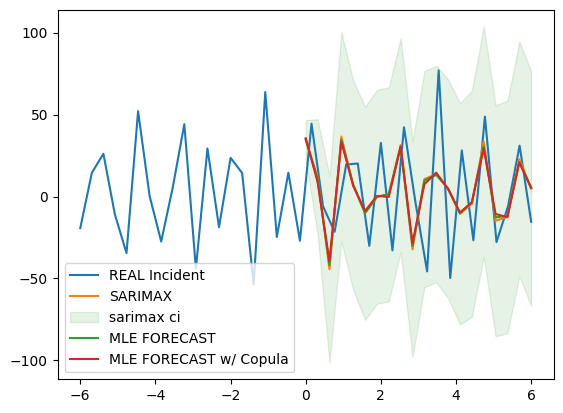

In [26]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,horizon*2),y_graph2)

ax.plot(np.linspace(0,6,horizon),sarimax_res2.forecast(horizon))
ax.fill_between(np.linspace(0,6,horizon), sarimax_ci_up2, sarimax_ci_down2, color='green', alpha=.1)

plt.plot(np.linspace(0,6,horizon),forecast_y2)
plt.plot(np.linspace(0,6,horizon),forecast2_param_copula)


plt.legend([ "REAL Incident", "SARIMAX", "sarimax ci",  "MLE FORECAST", "MLE FORECAST w/ Copula"])

plt.show()

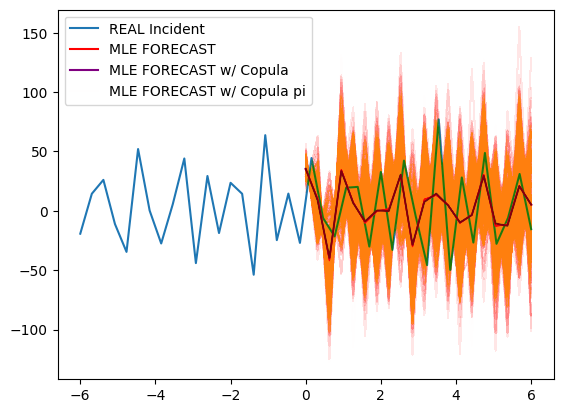

In [27]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,horizon*2),y_graph2)
plt.plot(np.linspace(0,6,horizon),forecast_y2, color = "red")
plt.plot(np.linspace(0,6,horizon),forecast2_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,horizon),pi_2[:,i],color='C1', alpha=.002)

plt.legend([ "REAL Incident",  "MLE FORECAST", "MLE FORECAST w/ Copula","MLE FORECAST w/ Copula pi" ])

plt.show()

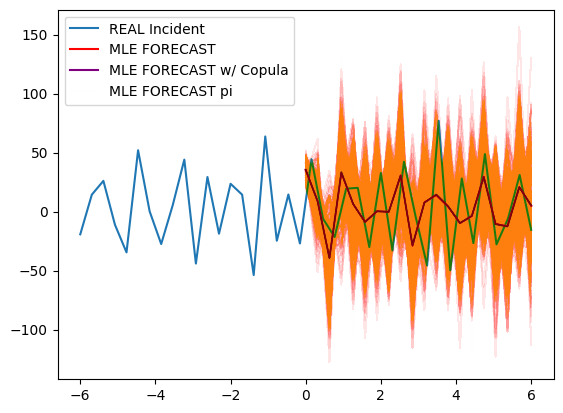

In [28]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,horizon*2),y_graph2)
plt.plot(np.linspace(0,6,horizon),forecast2b_param, color = "red")
plt.plot(np.linspace(0,6,horizon),forecast2_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,horizon),pi_2b[:,i],color='C1', alpha=.002)

plt.legend([ "REAL Incident",  "MLE FORECAST", "MLE FORECAST w/ Copula","MLE FORECAST pi" ])

plt.show()

In [29]:
print("MSE of predicted to true for MLE",mse(y2_test, forecast2b_param))
print("MSE of predicted to true for MLE w/ copula",mse(y2_test, forecast2_param_copula))
mse(forecast2b_param, forecast2_param_copula )

MSE of predicted to true for MLE [865.16955265]
MSE of predicted to true for MLE w/ copula 859.8698797514069


array([0.17511381])